Found 92 rows of 1h battery data
Available columns: ['config_id', 'power_mw', 'energy_mwh', 'scenario', 'dc_price_addition_percent', 'dam_weight', 'idm_weight', 'dc_weight', 'expected_return', 'portfolio_risk', 'duration']
Sample of data:
   config_id  power_mw  energy_mwh   scenario  dc_price_addition_percent  \
0          1        10          10  base_case                        0.0   
1          1        10          10   down_80%                      -80.0   
2          1        10          10   down_75%                      -75.0   
3          1        10          10   down_70%                      -70.0   
4          1        10          10   down_65%                      -65.0   

   dam_weight    idm_weight     dc_weight  expected_return  portfolio_risk  \
0    0.203999  7.840950e-16  7.960015e-01       726.268385      389.262760   
1    0.218570  7.814303e-01  0.000000e+00       467.025045      380.494598   
2    0.215747  7.842526e-01  0.000000e+00       467.097762      380.51

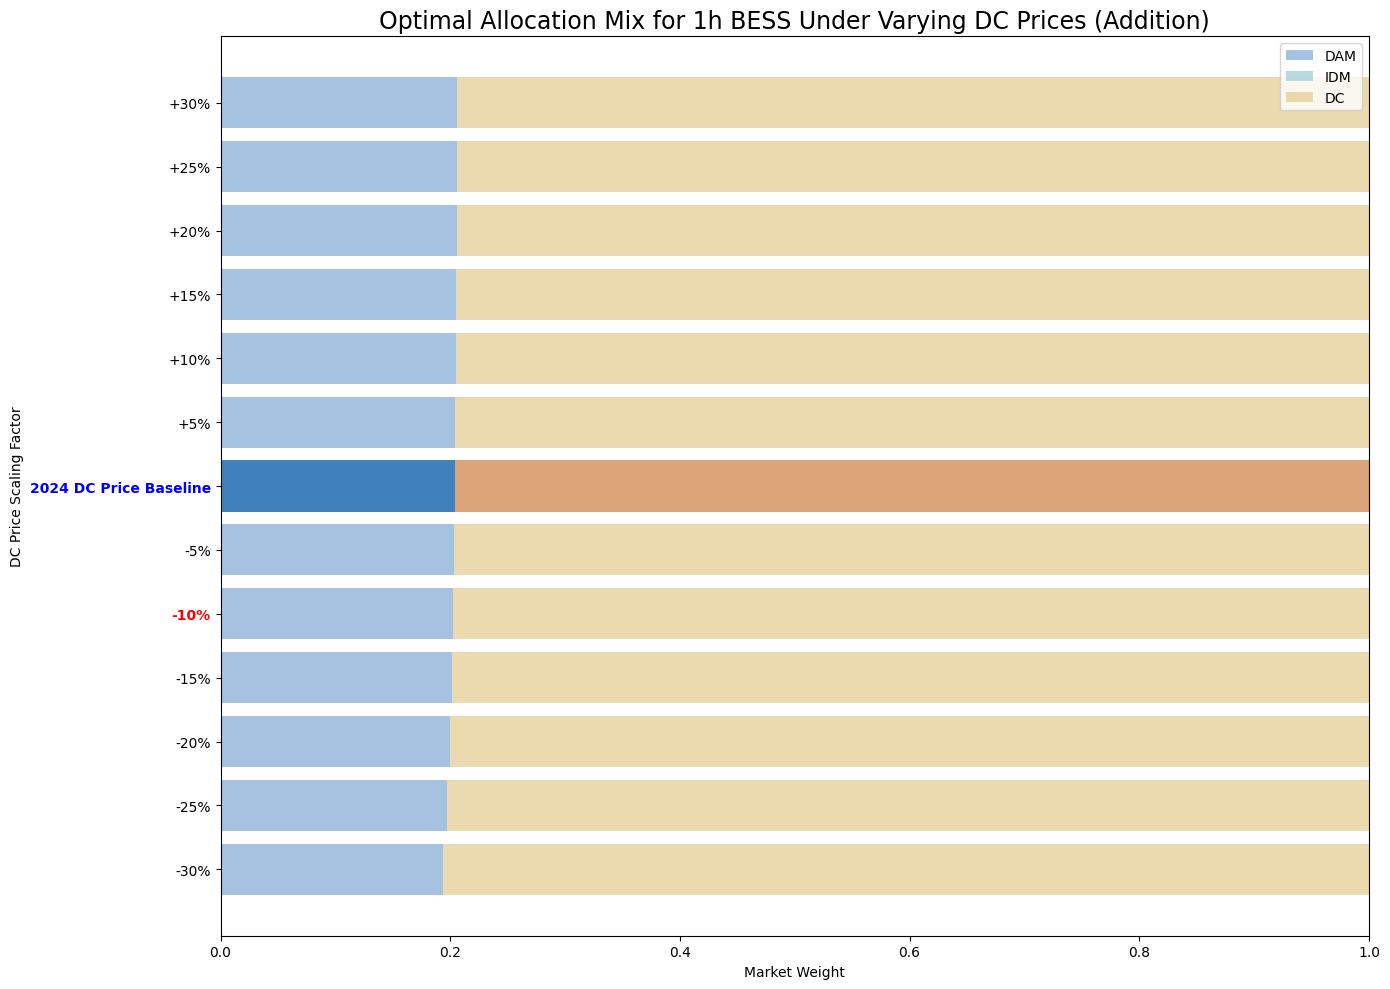

1-HOUR BATTERY: ALLOCATION BY DC PRICE SCALING (-30% to +30%)
      DC Price Scaling  DAM Weight  IDM Weight  DC Weight
                  -30%       0.194         0.0      0.806
                  -25%       0.197         0.0      0.803
                  -20%       0.200         0.0      0.800
                  -15%       0.201         0.0      0.799
                  -10%       0.202         0.0      0.798
                   -5%       0.203         0.0      0.797
2024 DC Price Baseline       0.204         0.0      0.796
                   +5%       0.205         0.0      0.795
                  +10%       0.205         0.0      0.795
                  +15%       0.205         0.0      0.795
                  +20%       0.206         0.0      0.794
                  +25%       0.206         0.0      0.794
                  +30%       0.206         0.0      0.794


In [12]:
#1-Hour Battery Analysis (scaling from -30% to +30%)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load 1-hour battery data
df_1h = pd.read_csv('Results for EDA/D*_price_addition_allocation_results.csv')
df_1h['duration'] = df_1h['energy_mwh'] / df_1h['power_mw']

# Filter for 1-hour batteries only
df_1h = df_1h[df_1h['duration'] == 1.0]

# Check if we have data for 1h batteries
if df_1h.empty:
    print("No 1h battery data found in the dataset")
else:
    print(f"Found {len(df_1h)} rows of 1h battery data")
    print("Available columns:", df_1h.columns.tolist())
    print("Sample of data:")
    print(df_1h.head())

    # Get unique scenarios for 1h data
    scenarios_1h = df_1h['scenario'].unique()
    print("Available scenarios:", scenarios_1h)

    # Create summary data for 1h battery
    summary_1h = []
    for scenario in scenarios_1h:
        scenario_data = df_1h[df_1h['scenario'] == scenario]
        if not scenario_data.empty:
            row = scenario_data.iloc[0]
            summary_1h.append({
                'scenario': scenario,
                'dc_price_addition_percent': row['dc_price_addition_percent'],
                'dam_weight': row['dam_weight'],
                'idm_weight': row['idm_weight'],
                'dc_weight': row['dc_weight']
            })

    summary_1h_df = pd.DataFrame(summary_1h)

    # Check if we have any data
    if summary_1h_df.empty:
        print("No summary data created - check data availability")
    else:
        # Filter for scaling factors from 0.7 to 1.3 (-30% to +30%)
        summary_1h_df = summary_1h_df[(summary_1h_df['dc_price_addition_percent'] >= -30) & 
                                        (summary_1h_df['dc_price_addition_percent'] <= 30)]

        # Create mapping from scale factor to percentage labels for 1h data (-30% to +30%)
        scale_to_label_1h = {
            -30: '-30%', -25: '-25%', -20: '-20%', -15: '-15%', 
            -10: '-10%', -5: '-5%',
            0: '2024 DC Price Baseline',
            5: '+5%', 10: '+10%', 15: '+15%', 20: '+20%', 25: '+25%', 30: '+30%'
        }
        
        # Single horizontal stacked bar chart for 1h battery
        fig, ax = plt.subplots(1, 1, figsize=(14, 10))
        
        # Base colors (full saturation for base case)
        base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
        # Less saturated colors for other scenarios
        light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#e6d19b'}

        # Sort by DC price scale
        subset_1h = summary_1h_df.sort_values('dc_price_addition_percent')
        y_pos = np.arange(len(subset_1h))

        # Create bars with different colors based on scenario
        for i, (idx, row) in enumerate(subset_1h.iterrows()):
            scale = row['dc_price_addition_percent']
            # Determine colors based on scenario
            if scale == 0:  # Base case
                colors = base_colors
            else:
                colors = light_colors
            # Horizontal stacked bars
            ax.barh(i, row['dam_weight'], label='DAM' if i == 0 else "", 
                    color=colors['DAM'], alpha=0.8)
            ax.barh(i, row['idm_weight'], left=row['dam_weight'], 
                    label='IDM' if i == 0 else "", color=colors['IDM'], alpha=0.8)
            ax.barh(i, row['dc_weight'], 
                    left=row['dam_weight'] + row['idm_weight'],
                    label='DC' if i == 0 else "", color=colors['DC'], alpha=0.8)
        
        ax.set_ylabel('DC Price Scaling Factor')
        ax.set_xlabel('Market Weight')
        ax.set_title('Optimal Allocation Mix for 1h BESS Under Varying DC Prices (Addition)', fontsize=17)
        ax.set_yticks(y_pos)
        
        # Create y-tick labels with special formatting
        y_labels = []
        for scale in subset_1h['dc_price_addition_percent']:
            label = scale_to_label_1h.get(scale, f"{scale:.2f}")
            y_labels.append(label)
        
        ax.set_yticklabels(y_labels)
        
        # Format specific labels with color and weight
        for i, (tick, scale) in enumerate(zip(ax.get_yticklabels(), subset_1h['dc_price_addition_percent'])):
            if scale in [-10]:  # -10% - highlighting relevant scale for 1h
                tick.set_color('red')
                tick.set_fontweight('bold')
            elif scale == 0:  # Base case
                tick.set_color('blue')
                tick.set_fontweight('bold')
        
        ax.legend()
        ax.grid(False)  # Remove grid
        ax.set_xlim(0, 1)
        
        plt.tight_layout()
        plt.show()

        # Summary table for 1h battery
        print("1-HOUR BATTERY: ALLOCATION BY DC PRICE SCALING (-30% to +30%)")
        print("=" * 70)
        summary_table = subset_1h[['dc_price_addition_percent', 'dam_weight', 'idm_weight', 'dc_weight']].copy()
        summary_table['price_label'] = [scale_to_label_1h.get(scale, f"{scale:.2f}") for scale in summary_table['dc_price_addition_percent']]
        summary_table = summary_table[['price_label', 'dam_weight', 'idm_weight', 'dc_weight']]
        summary_table.columns = ['DC Price Scaling', 'DAM Weight', 'IDM Weight', 'DC Weight']
        print(summary_table.round(3).to_string(index=False))

Found 69 rows of 1.5h battery data
Available columns: ['config_id', 'power_mw', 'energy_mwh', 'scenario', 'dc_price_addition_percent', 'dam_weight', 'idm_weight', 'dc_weight', 'expected_return', 'portfolio_risk', 'duration']
Sample of data:
    config_id  power_mw  energy_mwh   scenario  dc_price_addition_percent  \
92          5        10          15  base_case                        0.0   
93          5        10          15   down_80%                      -80.0   
94          5        10          15   down_75%                      -75.0   
95          5        10          15   down_70%                      -70.0   
96          5        10          15   down_65%                      -65.0   

      dam_weight  idm_weight     dc_weight  expected_return  portfolio_risk  \
92  3.069729e-16    0.284665  7.153353e-01       764.779159      528.183064   
93  8.500413e-01    0.149959  2.852364e-16       653.998494      492.168926   
94  8.483953e-01    0.151605  9.827167e-16       654.052004

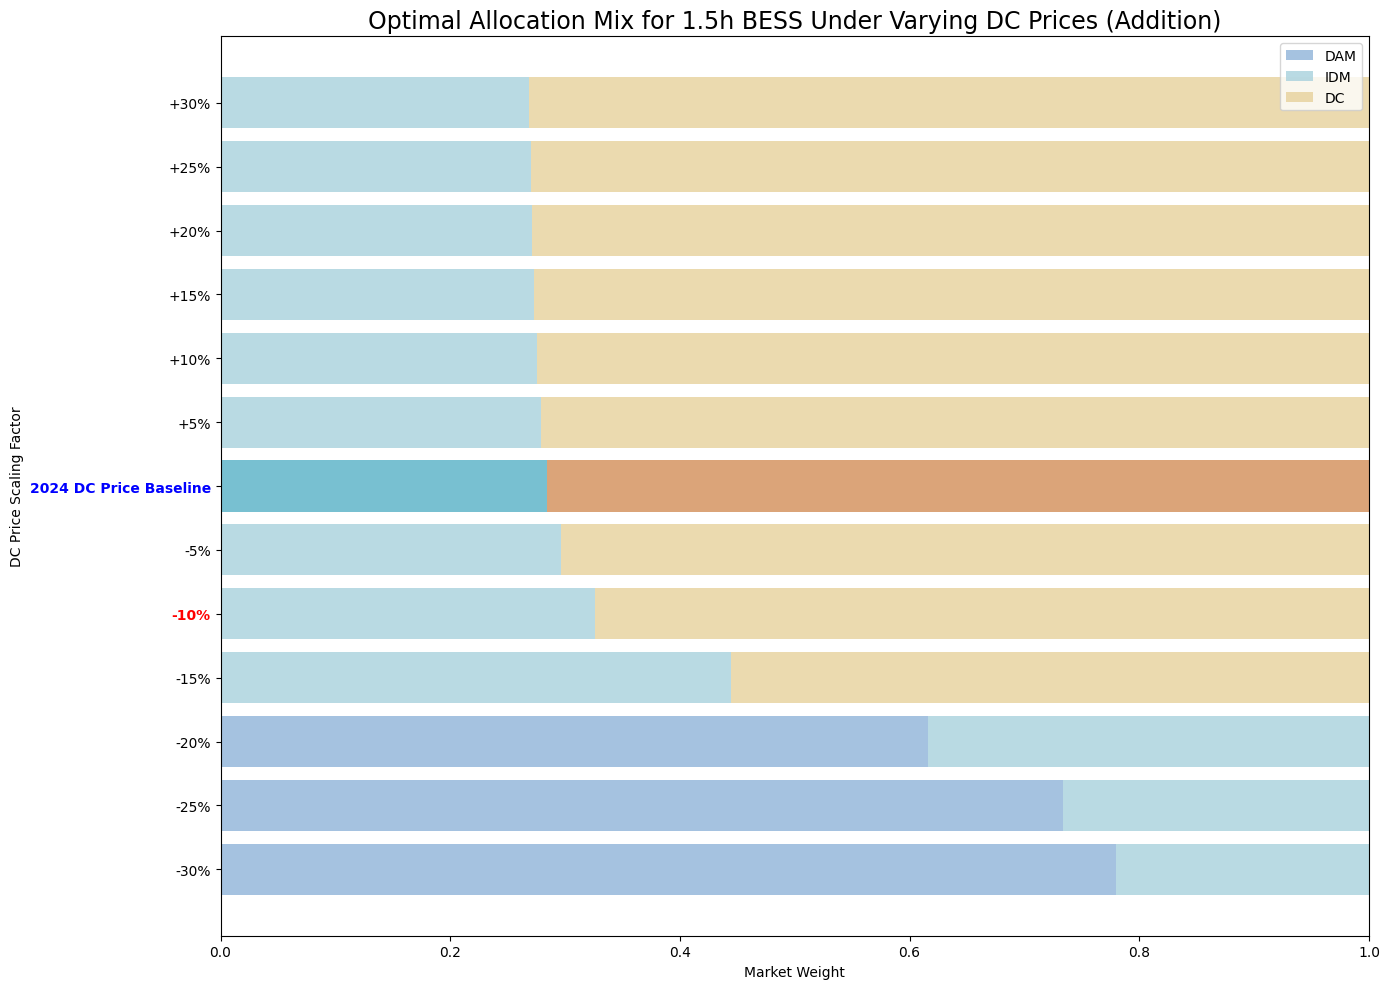

1.5-HOUR BATTERY: ALLOCATION BY DC PRICE SCALING (-30% to +30%)
      DC Price Scaling  DAM Weight  IDM Weight  DC Weight
                  -30%       0.780       0.220      0.000
                  -25%       0.733       0.267      0.000
                  -20%       0.616       0.384      0.000
                  -15%       0.000       0.445      0.555
                  -10%       0.000       0.326      0.674
                   -5%       0.000       0.296      0.704
2024 DC Price Baseline       0.000       0.285      0.715
                   +5%       0.000       0.279      0.721
                  +10%       0.000       0.275      0.725
                  +15%       0.000       0.273      0.727
                  +20%       0.000       0.271      0.729
                  +25%       0.000       0.270      0.730
                  +30%       0.000       0.269      0.731


In [10]:
#1.5-Hour Battery Analysis (scaling from -30% to +30%)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load 1.5-hour battery data
df_1_5h = pd.read_csv('Results for EDA/D*_price_addition_allocation_results.csv')
df_1_5h['duration'] = df_1_5h['energy_mwh'] / df_1_5h['power_mw']

# Filter for 1.5-hour batteries only
df_1_5h = df_1_5h[df_1_5h['duration'] == 1.5]

# Check if we have data for 1.5h batteries
if df_1_5h.empty:
    print("No 1.5h battery data found in the dataset")
else:
    print(f"Found {len(df_1_5h)} rows of 1.5h battery data")
    print("Available columns:", df_1_5h.columns.tolist())
    print("Sample of data:")
    print(df_1_5h.head())

    # Get unique scenarios for 1.5h data
    scenarios_1_5h = df_1_5h['scenario'].unique()
    print("Available scenarios:", scenarios_1_5h)

    # Create summary data for 1.5h battery
    summary_1_5h = []
    for scenario in scenarios_1_5h:
        scenario_data = df_1_5h[df_1_5h['scenario'] == scenario]
        if not scenario_data.empty:
            row = scenario_data.iloc[0]
            summary_1_5h.append({
                'scenario': scenario,
                'dc_price_addition_percent': row['dc_price_addition_percent'],
                'dam_weight': row['dam_weight'],
                'idm_weight': row['idm_weight'],
                'dc_weight': row['dc_weight']
            })

    summary_1_5h_df = pd.DataFrame(summary_1_5h)

    # Check if we have any data
    if summary_1h_df.empty:
        print("No summary data created - check data availability")
    else:
        # Filter for scaling factors from 0.7 to 1.3 (-30% to +30%)
        summary_1_5h_df = summary_1_5h_df[(summary_1_5h_df['dc_price_addition_percent'] >= -30) & 
                                        (summary_1_5h_df['dc_price_addition_percent'] <= 30)]

        # Create mapping from scale factor to percentage labels for 1.5h data (-30% to +30%)
        scale_to_label_1_5h = {
            -30: '-30%', -25: '-25%', -20: '-20%', -15: '-15%', 
            -10: '-10%', -5: '-5%',
            0: '2024 DC Price Baseline',
            5: '+5%', 10: '+10%', 15: '+15%', 20: '+20%', 25: '+25%', 30: '+30%'
        }
        
        # Single horizontal stacked bar chart for 1h battery
        fig, ax = plt.subplots(1, 1, figsize=(14, 10))
        
        # Base colors (full saturation for base case)
        base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
        # Less saturated colors for other scenarios
        light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#e6d19b'}

        # Sort by DC price scale
        subset_1_5h = summary_1_5h_df.sort_values('dc_price_addition_percent')
        y_pos = np.arange(len(subset_1_5h))
        
        # Create bars with different colors based on scenario
        for i, (idx, row) in enumerate(subset_1_5h.iterrows()):
            scale = row['dc_price_addition_percent']
            # Determine colors based on scenario
            if scale == 0:  # Base case
                colors = base_colors
            else:
                colors = light_colors
            # Horizontal stacked bars
            ax.barh(i, row['dam_weight'], label='DAM' if i == 0 else "", 
                    color=colors['DAM'], alpha=0.8)
            ax.barh(i, row['idm_weight'], left=row['dam_weight'], 
                    label='IDM' if i == 0 else "", color=colors['IDM'], alpha=0.8)
            ax.barh(i, row['dc_weight'], 
                    left=row['dam_weight'] + row['idm_weight'],
                    label='DC' if i == 0 else "", color=colors['DC'], alpha=0.8)
        
        ax.set_ylabel('DC Price Scaling Factor')
        ax.set_xlabel('Market Weight')
        ax.set_title('Optimal Allocation Mix for 1.5h BESS Under Varying DC Prices (Addition)', fontsize=17)
        ax.set_yticks(y_pos)
        
        # Create y-tick labels with special formatting
        y_labels = []
        for scale in subset_1_5h['dc_price_addition_percent']:
            label = scale_to_label_1_5h.get(scale, f"{scale:.2f}")
            y_labels.append(label)
        
        ax.set_yticklabels(y_labels)
        
        # Format specific labels with color and weight
        for i, (tick, scale) in enumerate(zip(ax.get_yticklabels(), subset_1_5h['dc_price_addition_percent'])):
            if scale in [-10]:  # -10% - highlighting relevant scale for 1.5h
                tick.set_color('red')
                tick.set_fontweight('bold')
            elif scale == 0:  # Base case
                tick.set_color('blue')
                tick.set_fontweight('bold')
        
        ax.legend()
        ax.grid(False)  # Remove grid
        ax.set_xlim(0, 1)
        
        plt.tight_layout()
        plt.show()

        # Summary table for 1.5h battery
        print("1.5-HOUR BATTERY: ALLOCATION BY DC PRICE SCALING (-30% to +30%)")
        print("=" * 70)
        summary_table = subset_1_5h[['dc_price_addition_percent', 'dam_weight', 'idm_weight', 'dc_weight']].copy()
        summary_table['price_label'] = [scale_to_label_1_5h.get(scale, f"{scale:.2f}") for scale in summary_table['dc_price_addition_percent']]
        summary_table = summary_table[['price_label', 'dam_weight', 'idm_weight', 'dc_weight']]
        summary_table.columns = ['DC Price Scaling', 'DAM Weight', 'IDM Weight', 'DC Weight']
        print(summary_table.round(3).to_string(index=False))

Found 161 rows of 2h battery data
Available columns: ['config_id', 'power_mw', 'energy_mwh', 'scenario', 'dc_price_addition_percent', 'dam_weight', 'idm_weight', 'dc_weight', 'expected_return', 'portfolio_risk', 'duration']
Sample of data:
     config_id  power_mw  energy_mwh   scenario  dc_price_addition_percent  \
161          8        10          20  base_case                        0.0   
162          8        10          20   down_80%                      -80.0   
163          8        10          20   down_75%                      -75.0   
164          8        10          20   down_70%                      -70.0   
165          8        10          20   down_65%                      -65.0   

     dam_weight    idm_weight     dc_weight  expected_return  portfolio_risk  \
161     0.75572  2.442797e-01  2.081668e-17       855.098801      642.269384   
162     1.00000  4.718448e-16  6.938894e-17       845.651530      609.229588   
163     1.00000  1.249001e-15  3.191891e-16       8

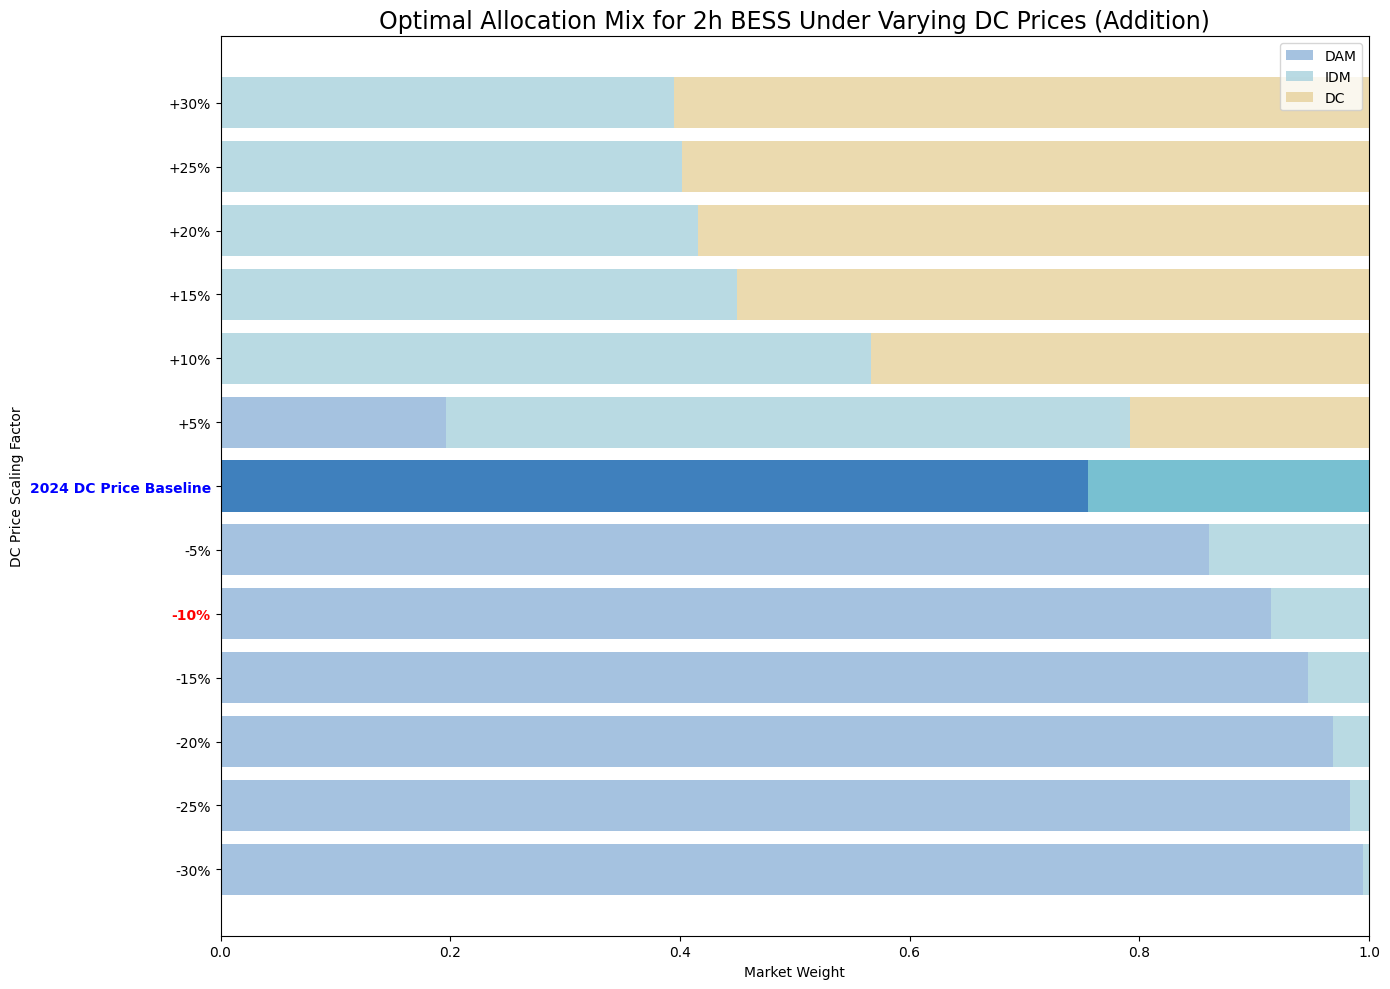

2-HOUR BATTERY: ALLOCATION BY DC PRICE SCALING (-30% to +30%)
      DC Price Scaling  DAM Weight  IDM Weight  DC Weight
                  -30%       0.995       0.005      0.000
                  -25%       0.984       0.016      0.000
                  -20%       0.968       0.032      0.000
                  -15%       0.947       0.053      0.000
                  -10%       0.914       0.086      0.000
                   -5%       0.860       0.140      0.000
2024 DC Price Baseline       0.756       0.244      0.000
                   +5%       0.196       0.596      0.208
                  +10%       0.000       0.566      0.434
                  +15%       0.000       0.449      0.551
                  +20%       0.000       0.415      0.585
                  +25%       0.000       0.402      0.598
                  +30%       0.000       0.395      0.605


In [9]:
#2-Hour Battery Analysis (scaling from -30% to +30%)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load 2-hour battery data
df_2h = pd.read_csv('Results for EDA/D*_price_addition_allocation_results.csv')
df_2h['duration'] = df_2h['energy_mwh'] / df_2h['power_mw']

# Filter for 2-hour batteries only
df_2h = df_2h[df_2h['duration'] == 2.0]

# Check if we have data for 2h batteries
if df_2h.empty:
    print("No 2h battery data found in the dataset")
else:
    print(f"Found {len(df_2h)} rows of 2h battery data")
    print("Available columns:", df_2h.columns.tolist())
    print("Sample of data:")
    print(df_2h.head())

    # Get unique scenarios for 2h data
    scenarios_2h = df_2h['scenario'].unique()
    print("Available scenarios:", scenarios_2h)

    # Create summary data for 2h battery
    summary_2h = []
    for scenario in scenarios_2h:
        scenario_data = df_2h[df_2h['scenario'] == scenario]
        if not scenario_data.empty:
            row = scenario_data.iloc[0]
            summary_2h.append({
                'scenario': scenario,
                'dc_price_addition_percent': row['dc_price_addition_percent'],
                'dam_weight': row['dam_weight'],
                'idm_weight': row['idm_weight'],
                'dc_weight': row['dc_weight']
            })

    summary_2h_df = pd.DataFrame(summary_2h)

    # Check if we have any data
    if summary_2h_df.empty:
        print("No summary data created - check data availability")
    else:
        # Filter for scaling factors from 0.7 to 1.3 (-30% to +30%)
        summary_2h_df = summary_2h_df[(summary_2h_df['dc_price_addition_percent'] >= -30) & 
                                        (summary_2h_df['dc_price_addition_percent'] <= 30)]

        # Create mapping from scale factor to percentage labels for 2h data (-30% to +30%)
        scale_to_label_2h = {
            -30: '-30%', -25: '-25%', -20: '-20%', -15: '-15%', 
            -10: '-10%', -5: '-5%',
            0: '2024 DC Price Baseline',
            5: '+5%', 10: '+10%', 15: '+15%', 20: '+20%', 25: '+25%', 30: '+30%'
        }
        
        # Single horizontal stacked bar chart for 1h battery
        fig, ax = plt.subplots(1, 1, figsize=(14, 10))
        
        # Base colors (full saturation for base case)
        base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
        # Less saturated colors for other scenarios
        light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#e6d19b'}

        # Sort by DC price scale
        subset_2h = summary_2h_df.sort_values('dc_price_addition_percent')
        y_pos = np.arange(len(subset_2h))

        # Create bars with different colors based on scenario
        for i, (idx, row) in enumerate(subset_2h.iterrows()):
            scale = row['dc_price_addition_percent']
            # Determine colors based on scenario
            if scale == 0:  # Base case
                colors = base_colors
            else:
                colors = light_colors
            # Horizontal stacked bars
            ax.barh(i, row['dam_weight'], label='DAM' if i == 0 else "", 
                    color=colors['DAM'], alpha=0.8)
            ax.barh(i, row['idm_weight'], left=row['dam_weight'], 
                    label='IDM' if i == 0 else "", color=colors['IDM'], alpha=0.8)
            ax.barh(i, row['dc_weight'], 
                    left=row['dam_weight'] + row['idm_weight'],
                    label='DC' if i == 0 else "", color=colors['DC'], alpha=0.8)
        
        ax.set_ylabel('DC Price Scaling Factor')
        ax.set_xlabel('Market Weight')
        ax.set_title('Optimal Allocation Mix for 2h BESS Under Varying DC Prices (Addition)', fontsize=17)
        ax.set_yticks(y_pos)
        
        # Create y-tick labels with special formatting
        y_labels = []
        for scale in subset_2h['dc_price_addition_percent']:
            label = scale_to_label_2h.get(scale, f"{scale:.2f}")
            y_labels.append(label)
        
        ax.set_yticklabels(y_labels)
        
        # Format specific labels with color and weight
        for i, (tick, scale) in enumerate(zip(ax.get_yticklabels(), subset_1h['dc_price_addition_percent'])):
            if scale in [-10]:  # -10% - highlighting relevant scale for 1h
                tick.set_color('red')
                tick.set_fontweight('bold')
            elif scale == 0:  # Base case
                tick.set_color('blue')
                tick.set_fontweight('bold')
        
        ax.legend()
        ax.grid(False)  # Remove grid
        ax.set_xlim(0, 1)
        
        plt.tight_layout()
        plt.show()

        # Summary table for 2h battery
        print("2-HOUR BATTERY: ALLOCATION BY DC PRICE SCALING (-30% to +30%)")
        print("=" * 70)
        summary_table = subset_2h[['dc_price_addition_percent', 'dam_weight', 'idm_weight', 'dc_weight']].copy()
        summary_table['price_label'] = [scale_to_label_2h.get(scale, f"{scale:.2f}") for scale in summary_table['dc_price_addition_percent']]
        summary_table = summary_table[['price_label', 'dam_weight', 'idm_weight', 'dc_weight']]
        summary_table.columns = ['DC Price Scaling', 'DAM Weight', 'IDM Weight', 'DC Weight']
        print(summary_table.round(3).to_string(index=False))

Found 46 rows of 3h battery data
Available columns: ['config_id', 'power_mw', 'energy_mwh', 'scenario', 'dc_price_addition_percent', 'dam_weight', 'idm_weight', 'dc_weight', 'expected_return', 'portfolio_risk', 'duration']
Sample of data:
     config_id  power_mw  energy_mwh   scenario  dc_price_addition_percent  \
322         15         5          15  base_case                        0.0   
323         15         5          15   down_80%                      -80.0   
324         15         5          15   down_75%                      -75.0   
325         15         5          15   down_70%                      -70.0   
326         15         5          15   down_65%                      -65.0   

     dam_weight    idm_weight     dc_weight  expected_return  portfolio_risk  \
322         1.0  1.110223e-16  2.775558e-17       594.150191      440.750357   
323         1.0  1.110223e-16  0.000000e+00       594.150191      440.750357   
324         1.0  0.000000e+00  0.000000e+00       59

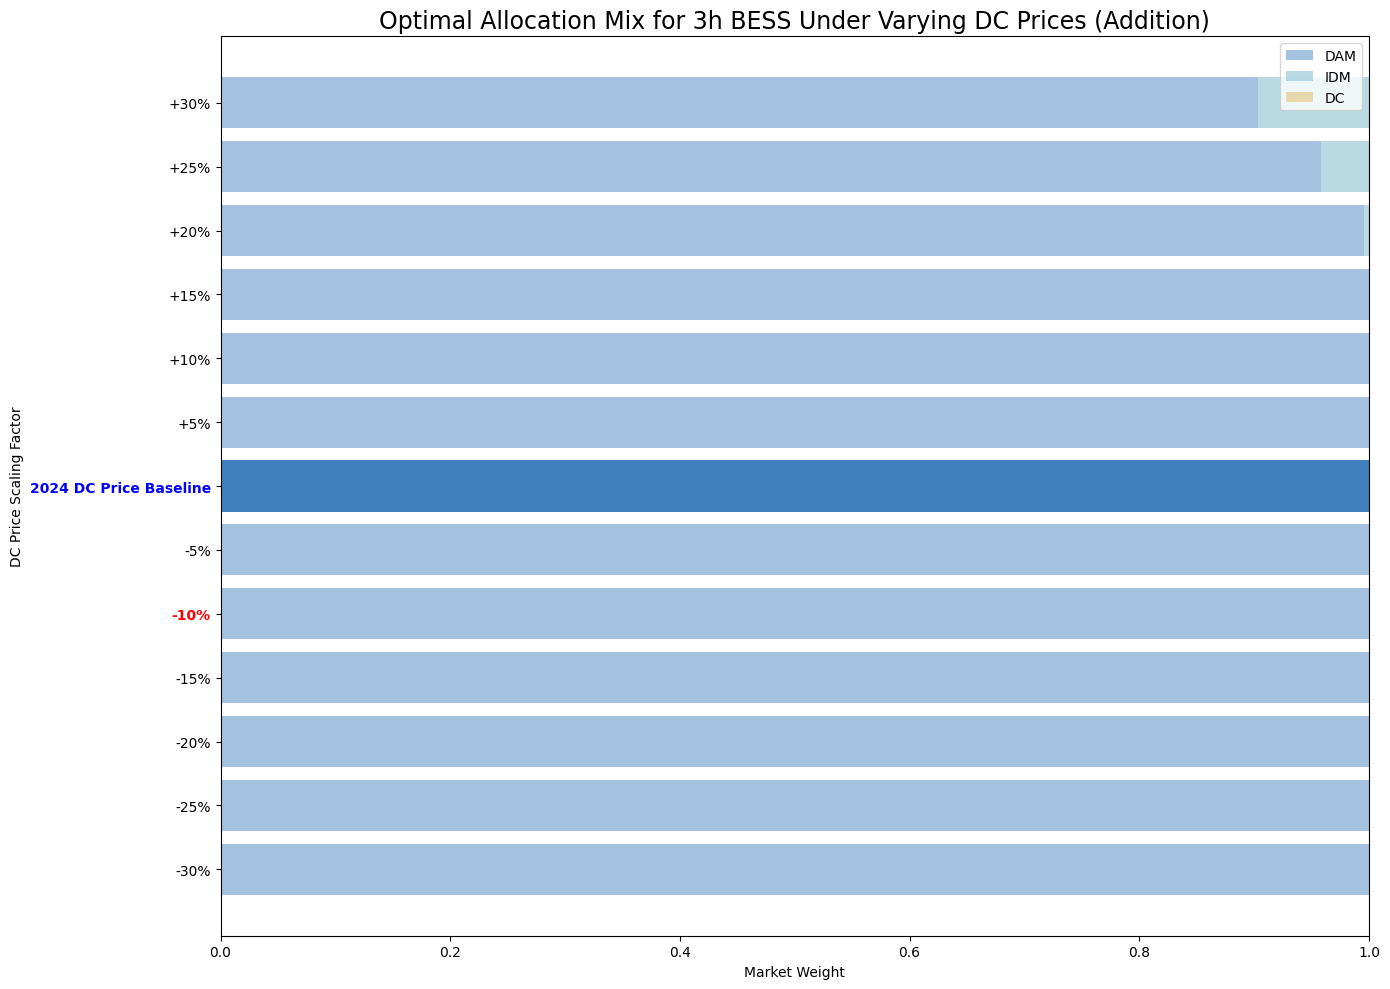

3-HOUR BATTERY: ALLOCATION BY DC PRICE SCALING (-30% to +30%)
      DC Price Scaling  DAM Weight  IDM Weight  DC Weight
                  -30%       1.000       0.000        0.0
                  -25%       1.000       0.000        0.0
                  -20%       1.000       0.000        0.0
                  -15%       1.000       0.000        0.0
                  -10%       1.000       0.000        0.0
                   -5%       1.000       0.000        0.0
2024 DC Price Baseline       1.000       0.000        0.0
                   +5%       1.000       0.000        0.0
                  +10%       1.000       0.000        0.0
                  +15%       1.000       0.000        0.0
                  +20%       0.995       0.005        0.0
                  +25%       0.958       0.042        0.0
                  +30%       0.904       0.096        0.0


In [13]:
#3-Hour Battery Analysis (scaling from -30% to +30%)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load 3-hour battery data
df_3h = pd.read_csv('Results for EDA/D*_price_addition_allocation_results.csv')
df_3h['duration'] = df_3h['energy_mwh'] / df_3h['power_mw']

# Filter for 3-hour batteries only
df_3h = df_3h[df_3h['duration'] == 3.0]

# Check if we have data for 3h batteries
if df_3h.empty:
    print("No 3h battery data found in the dataset")
else:
    print(f"Found {len(df_3h)} rows of 3h battery data")
    print("Available columns:", df_3h.columns.tolist())
    print("Sample of data:")
    print(df_3h.head())

    # Get unique scenarios for 3h data
    scenarios_3h = df_3h['scenario'].unique()
    print("Available scenarios:", scenarios_3h)

    # Create summary data for 3h battery
    summary_3h = []
    for scenario in scenarios_3h:
        scenario_data = df_3h[df_3h['scenario'] == scenario]
        if not scenario_data.empty:
            row = scenario_data.iloc[0]
            summary_3h.append({
                'scenario': scenario,
                'dc_price_addition_percent': row['dc_price_addition_percent'],
                'dam_weight': row['dam_weight'],
                'idm_weight': row['idm_weight'],
                'dc_weight': row['dc_weight']
            })

    summary_3h_df = pd.DataFrame(summary_3h)

    # Check if we have any data
    if summary_3h_df.empty:
        print("No summary data created - check data availability")
    else:
        # Filter for scaling factors from 0.7 to 1.3 (-30% to +30%)
        summary_3h_df = summary_3h_df[(summary_3h_df['dc_price_addition_percent'] >= -30) & 
                                        (summary_3h_df['dc_price_addition_percent'] <= 30)]

        # Create mapping from scale factor to percentage labels for 3h data (-30% to +30%)
        scale_to_label_3h = {
            -30: '-30%', -25: '-25%', -20: '-20%', -15: '-15%', 
            -10: '-10%', -5: '-5%',
            0: '2024 DC Price Baseline',
            5: '+5%', 10: '+10%', 15: '+15%', 20: '+20%', 25: '+25%', 30: '+30%'
        }

        # Single horizontal stacked bar chart for 3h battery
        fig, ax = plt.subplots(1, 1, figsize=(14, 10))
        
        # Base colors (full saturation for base case)
        base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
        # Less saturated colors for other scenarios
        light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#e6d19b'}

        # Sort by DC price scale
        subset_3h = summary_3h_df.sort_values('dc_price_addition_percent')
        y_pos = np.arange(len(subset_3h))

        # Create bars with different colors based on scenario
        for i, (idx, row) in enumerate(subset_3h.iterrows()):
            scale = row['dc_price_addition_percent']
            # Determine colors based on scenario
            if scale == 0:  # Base case
                colors = base_colors
            else:
                colors = light_colors
            # Horizontal stacked bars
            ax.barh(i, row['dam_weight'], label='DAM' if i == 0 else "", 
                    color=colors['DAM'], alpha=0.8)
            ax.barh(i, row['idm_weight'], left=row['dam_weight'], 
                    label='IDM' if i == 0 else "", color=colors['IDM'], alpha=0.8)
            ax.barh(i, row['dc_weight'], 
                    left=row['dam_weight'] + row['idm_weight'],
                    label='DC' if i == 0 else "", color=colors['DC'], alpha=0.8)
        
        ax.set_ylabel('DC Price Scaling Factor')
        ax.set_xlabel('Market Weight')
        ax.set_title('Optimal Allocation Mix for 3h BESS Under Varying DC Prices (Addition)', fontsize=17)
        ax.set_yticks(y_pos)
        
        # Create y-tick labels with special formatting
        y_labels = []
        for scale in subset_3h['dc_price_addition_percent']:
            label = scale_to_label_3h.get(scale, f"{scale:.2f}")
            y_labels.append(label)
        
        ax.set_yticklabels(y_labels)
        
        # Format specific labels with color and weight
        for i, (tick, scale) in enumerate(zip(ax.get_yticklabels(), subset_1h['dc_price_addition_percent'])):
            if scale in [-10]:  # -10% - highlighting relevant scale for 1h
                tick.set_color('red')
                tick.set_fontweight('bold')
            elif scale == 0:  # Base case
                tick.set_color('blue')
                tick.set_fontweight('bold')
        
        ax.legend()
        ax.grid(False)  # Remove grid
        ax.set_xlim(0, 1)
        
        plt.tight_layout()
        plt.show()

        # Summary table for 3h battery
        print("3-HOUR BATTERY: ALLOCATION BY DC PRICE SCALING (-30% to +30%)")
        print("=" * 70)
        summary_table = subset_3h[['dc_price_addition_percent', 'dam_weight', 'idm_weight', 'dc_weight']].copy()
        summary_table['price_label'] = [scale_to_label_3h.get(scale, f"{scale:.2f}") for scale in summary_table['dc_price_addition_percent']]
        summary_table = summary_table[['price_label', 'dam_weight', 'idm_weight', 'dc_weight']]
        summary_table.columns = ['DC Price Scaling', 'DAM Weight', 'IDM Weight', 'DC Weight']
        print(summary_table.round(3).to_string(index=False))

Found 23 rows of 4h battery data
Available columns: ['config_id', 'power_mw', 'energy_mwh', 'scenario', 'dc_price_addition_percent', 'dam_weight', 'idm_weight', 'dc_weight', 'expected_return', 'portfolio_risk', 'duration']
Sample of data:
     config_id  power_mw  energy_mwh   scenario  dc_price_addition_percent  \
368         17        15          60  base_case                        0.0   
369         17        15          60   down_80%                      -80.0   
370         17        15          60   down_75%                      -75.0   
371         17        15          60   down_70%                      -70.0   
372         17        15          60   down_65%                      -65.0   

     dam_weight    idm_weight  dc_weight  expected_return  portfolio_risk  \
368    0.990302  1.387779e-17   0.009698      2181.048445     1677.562155   
369    0.995467  0.000000e+00   0.004533      2181.842099     1681.891299   
370    0.995277  0.000000e+00   0.004723      2181.754039    

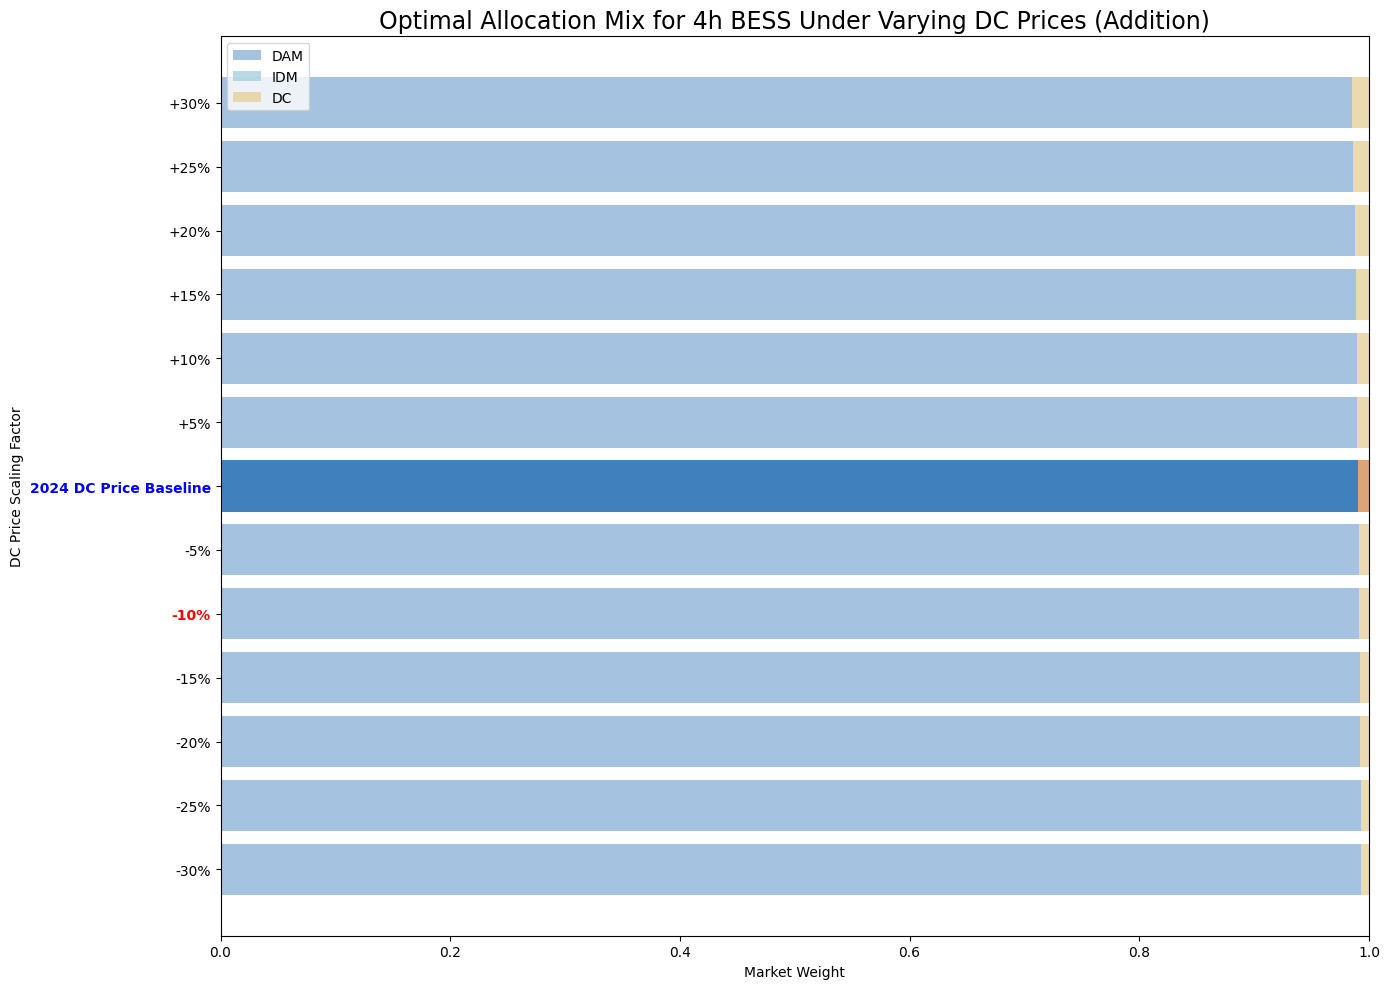

4-HOUR BATTERY: ALLOCATION BY DC PRICE SCALING (-30% to +30%)
      DC Price Scaling  DAM Weight  IDM Weight  DC Weight
                  -30%       0.993         0.0      0.007
                  -25%       0.993         0.0      0.007
                  -20%       0.992         0.0      0.008
                  -15%       0.992         0.0      0.008
                  -10%       0.991         0.0      0.009
                   -5%       0.991         0.0      0.009
2024 DC Price Baseline       0.990         0.0      0.010
                   +5%       0.990         0.0      0.010
                  +10%       0.989         0.0      0.011
                  +15%       0.988         0.0      0.012
                  +20%       0.987         0.0      0.013
                  +25%       0.986         0.0      0.014
                  +30%       0.985         0.0      0.015


In [14]:
#4-Hour Battery Analysis (scaling from -30% to +30%)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load 4-hour battery data
df_4h = pd.read_csv('Results for EDA/D*_price_addition_allocation_results.csv')
df_4h['duration'] = df_4h['energy_mwh'] / df_4h['power_mw']

# Filter for 4-hour batteries only
df_4h = df_4h[df_4h['duration'] == 4.0]

# Check if we have data for 4h batteries
if df_4h.empty:
    print("No 4h battery data found in the dataset")
else:
    print(f"Found {len(df_4h)} rows of 4h battery data")
    print("Available columns:", df_4h.columns.tolist())
    print("Sample of data:")
    print(df_4h.head())

    # Get unique scenarios for 4h data
    scenarios_4h = df_4h['scenario'].unique()
    print("Available scenarios:", scenarios_4h)

    # Create summary data for 4h battery
    summary_4h = []
    for scenario in scenarios_4h:
        scenario_data = df_4h[df_4h['scenario'] == scenario]
        if not scenario_data.empty:
            row = scenario_data.iloc[0]
            summary_4h.append({
                'scenario': scenario,
                'dc_price_addition_percent': row['dc_price_addition_percent'],
                'dam_weight': row['dam_weight'],
                'idm_weight': row['idm_weight'],
                'dc_weight': row['dc_weight']
            })

    summary_4h_df = pd.DataFrame(summary_4h)

    # Check if we have any data
    if summary_4h_df.empty:
        print("No summary data created - check data availability")
    else:
        # Filter for scaling factors from 0.7 to 1.3 (-30% to +30%)
        summary_4h_df = summary_4h_df[(summary_4h_df['dc_price_addition_percent'] >= -30) & 
                                        (summary_4h_df['dc_price_addition_percent'] <= 30)]

        # Create mapping from scale factor to percentage labels for 4h data (-30% to +30%)
        scale_to_label_4h = {
            -30: '-30%', -25: '-25%', -20: '-20%', -15: '-15%', 
            -10: '-10%', -5: '-5%',
            0: '2024 DC Price Baseline',
            5: '+5%', 10: '+10%', 15: '+15%', 20: '+20%', 25: '+25%', 30: '+30%'
        }

        # Single horizontal stacked bar chart for 4h battery
        fig, ax = plt.subplots(1, 1, figsize=(14, 10))
        
        # Base colors (full saturation for base case)
        base_colors = {'DAM': '#0f61ad99', 'IDM': '#56b1c6c7', 'DC': '#d38d5763'}
        # Less saturated colors for other scenarios
        light_colors = {'DAM': '#8fb3d9', 'IDM': '#a8d1dd', 'DC': '#e6d19b'}

        # Sort by DC price scale
        subset_4h = summary_4h_df.sort_values('dc_price_addition_percent')
        y_pos = np.arange(len(subset_4h))

        # Create bars with different colors based on scenario
        for i, (idx, row) in enumerate(subset_4h.iterrows()):
            scale = row['dc_price_addition_percent']
            # Determine colors based on scenario
            if scale == 0:  # Base case
                colors = base_colors
            else:
                colors = light_colors
            # Horizontal stacked bars
            ax.barh(i, row['dam_weight'], label='DAM' if i == 0 else "", 
                    color=colors['DAM'], alpha=0.8)
            ax.barh(i, row['idm_weight'], left=row['dam_weight'], 
                    label='IDM' if i == 0 else "", color=colors['IDM'], alpha=0.8)
            ax.barh(i, row['dc_weight'], 
                    left=row['dam_weight'] + row['idm_weight'],
                    label='DC' if i == 0 else "", color=colors['DC'], alpha=0.8)
        
        ax.set_ylabel('DC Price Scaling Factor')
        ax.set_xlabel('Market Weight')
        ax.set_title('Optimal Allocation Mix for 4h BESS Under Varying DC Prices (Addition)', fontsize=17)
        ax.set_yticks(y_pos)
        
        # Create y-tick labels with special formatting
        y_labels = []
        for scale in subset_4h['dc_price_addition_percent']:
            label = scale_to_label_4h.get(scale, f"{scale:.2f}")
            y_labels.append(label)
        
        ax.set_yticklabels(y_labels)
        
        # Format specific labels with color and weight
        for i, (tick, scale) in enumerate(zip(ax.get_yticklabels(), subset_4h['dc_price_addition_percent'])):
            if scale in [-10]:  # -10% - highlighting relevant scale for 4h
                tick.set_color('red')
                tick.set_fontweight('bold')
            elif scale == 0:  # Base case
                tick.set_color('blue')
                tick.set_fontweight('bold')
        
        ax.legend()
        ax.grid(False)  # Remove grid
        ax.set_xlim(0, 1)
        
        plt.tight_layout()
        plt.show()

        # Summary table for 4h battery
        print("4-HOUR BATTERY: ALLOCATION BY DC PRICE SCALING (-30% to +30%)")
        print("=" * 70)
        summary_table = subset_4h[['dc_price_addition_percent', 'dam_weight', 'idm_weight', 'dc_weight']].copy()
        summary_table['price_label'] = [scale_to_label_4h.get(scale, f"{scale:.2f}") for scale in summary_table['dc_price_addition_percent']]
        summary_table = summary_table[['price_label', 'dam_weight', 'idm_weight', 'dc_weight']]
        summary_table.columns = ['DC Price Scaling', 'DAM Weight', 'IDM Weight', 'DC Weight']
        print(summary_table.round(3).to_string(index=False))